In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[2], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import tensorflow.keras as keras
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights
from models import VAE_Model as NNmodel
from data_and_eval_utils import load_preprocessed_snl, plot_rocs, get_truth_and_scores, AD_score_KL

2025-07-14 10:05:03.000406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-14 10:05:04.067732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# def AD_score_KL(z_mean, z_log_var):
#     kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
#     # Comparing this to eq 2 in arXiv: 2108.03986 z_log_var = log(sigma**2)
#     return kl_loss


# def AD_score_CKL(z_mean, _): # z_log_var not used
#     CKL = np.mean(z_mean**2)
#     return CKL 

# def AD_score_Rz(z_mean, z_log_var):
#     return z_mean**2/np.exp(z_log_var)



# def get_truth_and_scores(encoder, AD_metric, debug=True):
#     bg_score, bad_model = calc_anomaly_scores(X_test, encoder, AD_metric)
#     scores = []
#     truths = []
#     zeros = np.zeros(len(X_test))
#     signal_data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data]

#     # Generate Truth and score lists ready for ROC curve calculation
#     if not(bad_model):
#         for dat in signal_data:
#             truths.append(np.concatenate((zeros, np.ones(len(dat)))))

#             s, _ = calc_anomaly_scores(dat, encoder, AD_metric, debug=debug)
#             scores.append(np.concatenate((bg_score,s) ))

#     return (truths, scores, bad_model)

In [3]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
# with h5py.File(file_path, 'r') as hf:           # Shapes:
#     X_train = hf['X_train'][:]                  # (3200000, 57)
#     X_test  = hf['X_test'][:]                   # (800000,  57)
#     Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data? 
#     hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57)
#     hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57)
#     leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57)
#     print("Data loaded from preprocessed_SNL_data.h5")

data = load_preprocessed_snl()

# def plot_rocs(truths, scores, fig_title):
#     target_fpr = 1e-5
#     tpr_at_target = []
#     signal_names_tex = [ # latex version
#                     "Leptoquark"
#                     , "$A\\rightarrow 4\ell$"
#                     , "$h^{\pm}\\rightarrow\\tau \\nu$"
#                     , "$h^0\\rightarrow\\tau\\tau$"
#                     ]
#     signal_names_hum = [ # human readable
#                     "Leptoquark"
#                     ,"A to 4L"
#                     , "h to Tau Nu"
#                     , "h to Tau Tau"
#                     ]
#     fig, ax = plt.subplots()

#     for truth, score, l in zip(truths, scores, signal_names_tex):
#         fpr, tpr, thresholds = roc_curve(truth, score)
#         auc = sk.roc_auc_score(truth, score)
#         ax.plot(fpr, tpr, label=l + f": {str(round(auc, 3))}") # plot roc curve



#         # Find tpr at fpr target
#         idx = np.argmin(np.abs(fpr - target_fpr))
#         tpr_at_target.append(tpr[idx])
        
#     ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--")
#     ax.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")

#     # Plot teaks
#     ax.loglog()
#     ax.legend()
#     ax.grid()
#     ax.set_xlabel("fpr")
#     ax.set_ylabel("tpr")
#     ax.set_title(fig_title) 
#     plt.show()

#     for sig_nam, tpr in zip(signal_names_hum, tpr_at_target):
#         print(sig_nam + " TPR @ FPR 10e-5 (%): " + f"{tpr*100:.2f}")

#     return fig



Data loaded from preprocessed_SNL_data.h5


##### We will now search for the best performing model. 

2025-07-14 10:05:09.545469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 877 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-07-14 10:05:09.547505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37946 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-07-14 10:05:09.549439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37946 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2025-07-14 10:05:09.551372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37946 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus 

  230/25000 [..............................] - ETA: 16s  

2025-07-14 10:05:10.258868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1750/1750 [==============================] - 1s 761us/step
Unstable model: inf encountered. Rejecting Modelz_mean: -6.749490737915039
z_log_var: 109.84550476074219
    1/23759 [..............................] - ETA: 22:22

/tmp/ipykernel_271379/996140657.py:2: RuntimeWarning: overflow encountered in exp
  kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))


23759/23759 [==============================] - 20s 850us/step
Unstable model: inf encountered. Rejecting Modelz_mean: 4.187585830688477
z_log_var: 91.46282958984375
21603/21603 [==============================] - 18s 845us/step
Unstable model: inf encountered. Rejecting Modelz_mean: -29.637027740478516
z_log_var: 118.01856994628906


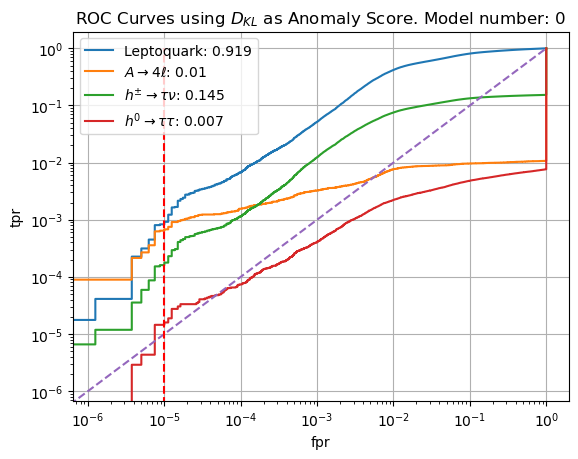

Leptoquark TPR @ FPR 10e-5 (%): 0.08
A to 4L TPR @ FPR 10e-5 (%): 0.06
h to Tau Nu TPR @ FPR 10e-5 (%): 0.02
h to Tau Tau TPR @ FPR 10e-5 (%): 0.00
21603/21603 [==============================] - 18s 825us/step


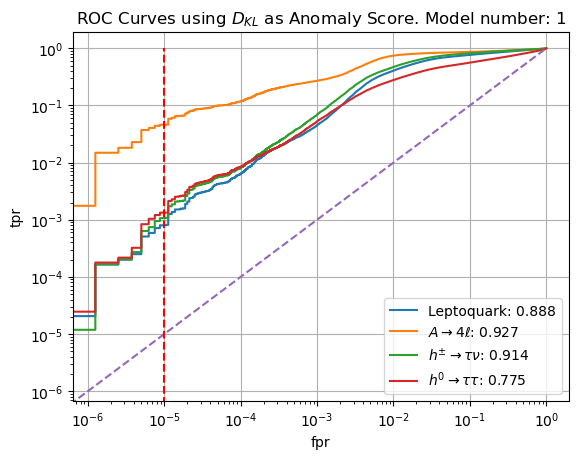

Leptoquark TPR @ FPR 10e-5 (%): 0.08
A to 4L TPR @ FPR 10e-5 (%): 4.59
h to Tau Nu TPR @ FPR 10e-5 (%): 0.11
h to Tau Tau TPR @ FPR 10e-5 (%): 0.13
21603/21603 [==============================] - 18s 846us/step


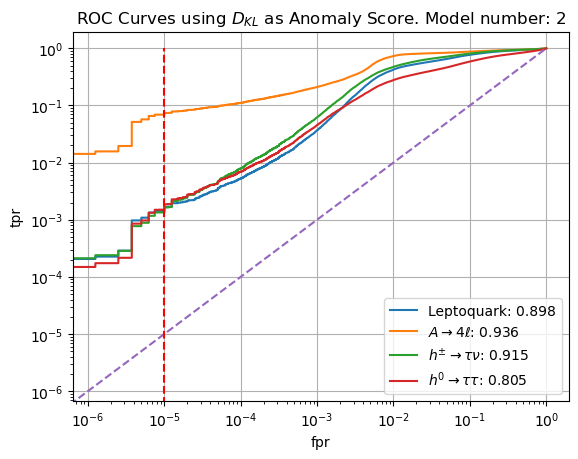

Leptoquark TPR @ FPR 10e-5 (%): 0.14
A to 4L TPR @ FPR 10e-5 (%): 6.91
h to Tau Nu TPR @ FPR 10e-5 (%): 0.13
h to Tau Tau TPR @ FPR 10e-5 (%): 0.15
21603/21603 [==============================] - 17s 790us/step


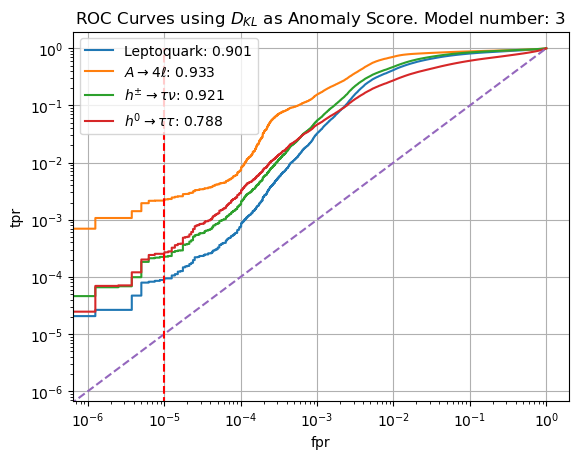

Leptoquark TPR @ FPR 10e-5 (%): 0.01
A to 4L TPR @ FPR 10e-5 (%): 0.22
h to Tau Nu TPR @ FPR 10e-5 (%): 0.02
h to Tau Tau TPR @ FPR 10e-5 (%): 0.03
21603/21603 [==============================] - 17s 784us/step


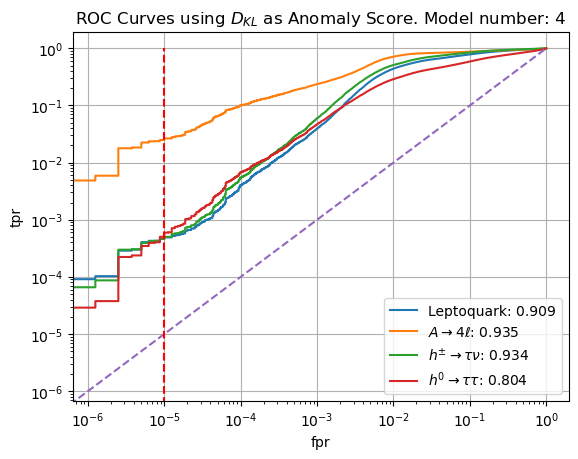

Leptoquark TPR @ FPR 10e-5 (%): 0.05
A to 4L TPR @ FPR 10e-5 (%): 2.48
h to Tau Nu TPR @ FPR 10e-5 (%): 0.05
h to Tau Tau TPR @ FPR 10e-5 (%): 0.05
1750/1750 [==============================] - 2s 858us/step
Unstable model: inf encountered. Rejecting Modelz_mean: 239.44667053222656
z_log_var: 145.95050048828125
    1/23759 [..............................] - ETA: 24:21

/tmp/ipykernel_271379/996140657.py:2: RuntimeWarning: overflow encountered in exp
  kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))


21603/21603 [==============================] - 17s 764us/step


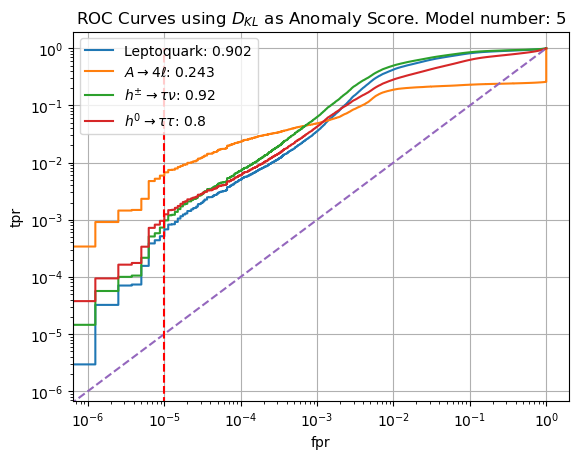

Leptoquark TPR @ FPR 10e-5 (%): 0.05
A to 4L TPR @ FPR 10e-5 (%): 0.59
h to Tau Nu TPR @ FPR 10e-5 (%): 0.07
h to Tau Tau TPR @ FPR 10e-5 (%): 0.10
21603/21603 [==============================] - 14s 646us/step


In [ ]:
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_TRAIN = 20 # number of trained models

SAVE_PATH = home_path+f"/VAE_trainings/attempt2/old_cyclical_beta/" # As of 7/10/25. should be synced with vae0_analysis
bad_models = []
SAVE_FIG = True
FILE_NAMES = "old_beta_sheduling"
FIG_SAVE_PATH = SAVE_PATH + "plots/"
for i in range(NUM_TRAIN):
    new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
    new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
    new_VAE = NNmodel(new_enc, new_dec)
    save_path = SAVE_PATH + f"n_{i}/"

    new_VAE.load_weights(save_path)

    just_enc = new_VAE.get_layer("encoder") # We only need encoder output
    t, s, bad_model = get_truth_and_scores(just_enc, AD_score_KL)
    if bad_model:
        print(f"Unstable mode. Inf encountered. Model number {i} ")
        bad_models.append(i)
        continue


    f = plot_rocs(t, s, "ROC Curves using $D_{KL}$ as Anomaly Score. Model number: " + str(i))

    if SAVE_FIG:
        f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")